# **MovieLens: Exploratory Data Analysis**

Movie lens dataset consist of 25 million ratings from around 160 thousand users
for 59,000 movies for different genres from Action to Adventure.

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import scipy.sparse as sparse
import xgboost as xgb
import sklearn
from urllib.request import urlretrieve
import zipfile

Downloading and loading the dataset into pandas dataframe

In [3]:
# Download MovieLens data.
print("Downloading movielens data...")


urlretrieve("http://files.grouplens.org/datasets/movielens/ml-25m.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done.")

Done.


We will be using movies, ratings and tags table to perform data analysis

**movies.csv**: This file contains details about the movies, including the movie ID, title, release year, and genres.

**ratings.csv**: This file contains user-submitted movie ratings along with the user ID, movie ID, rating, and timestamp.

**tags.csv**: This file contains the tags that users have assigned to movies, including the user ID, movie ID, tag, and timestamp.

In [4]:
movies = pd.read_csv('ml-25m/movies.csv')
ratings = pd.read_csv('ml-25m/ratings.csv')
tags = pd.read_csv('ml-25m/tags.csv')

#**Data Cleaning**

Data cleaning steps - 
1. Sort the data
2. Extract the year from title in movies
3. Create a unique genres dataframe
4. Dropping NA

In [5]:
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

# Categorize movies genres properly
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)
movies.dropna(inplace=True)

movies.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995.0,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year
ratings.dropna(inplace=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

ratings.head()

,userId,movieId,rating,timestamp
0,13334,1,5.0,1970
1,35495,1,4.5,1970
2,103039,1,4.0,1970
3,49712,1,5.0,1970
4,103038,1,2.5,1970


#**Data Analysis**

We will now plot various graphs to find interesting insights in the movielens dataset.

**Number of movies released each decade**


Let's take a look at how many movies are released each decade

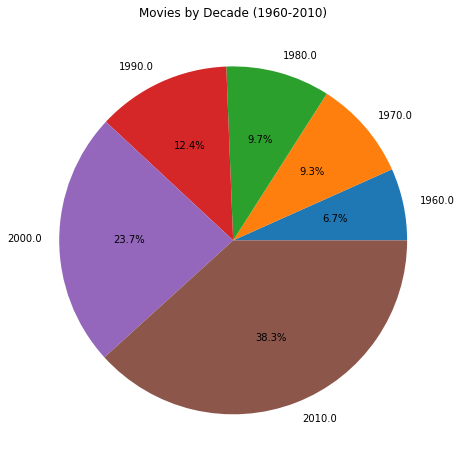

In [7]:
moviesold = movies
# create a new column for the decade of release
movies['decade'] = (movies['year'] // 10) * 10

# filter movies released between 1960 and 2010
movies = movies[(movies['decade'] >= 1960) & (movies['decade'] < 2020)]

# group movies by decade and count the number of movies
movies_by_decade = movies.groupby('decade')['movieId'].count()

# create a pie chart
fig = plt.figure(figsize=(8, 8))
plt.pie(movies_by_decade, labels=movies_by_decade.index, autopct='%1.1f%%')
plt.title('Movies by Decade (1960-2010)')
plt.show()

We can observe that released each decade is increasing significantly

**Cumulative number of movies by genre and year**

Let's find out how many movies are released each year stacked with the number of genres to find out how each genre has increased over the year

<Figure size 720x360 with 0 Axes>

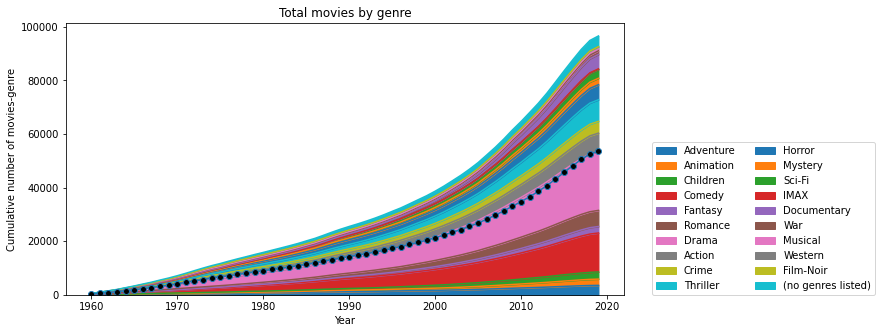

In [9]:
# Set figure size
plt.figure(figsize=(10,5))

# Group movies by year
movies_by_year = movies.groupby('year')

# Create a DataFrame with the cumulative count of all movies
df = pd.DataFrame({'All_movies' : movies_by_year.movieId.nunique().cumsum()})

# Loop over unique genres and add their cumulative counts to the DataFrame
for genre in genres_unique.genre:
    # Subset movies by the current genre and group them by year
    genre_movies = movies[movies[genre]]
    genre_movies_by_year = genre_movies.groupby('year')
    # Add the cumulative count of the current genre to the DataFrame
    df[genre] = genre_movies_by_year.movieId.nunique().cumsum()

# Fill missing values with the previous ones
df.fillna(method='ffill', inplace=True)

# Plot stacked area chart for each genre
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))

# Plot line chart for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')

# Set axis labels and title
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies by genre') # Note that many movies have multiple genres

# Set legend outside of the plot area
plt.legend(loc=(1.05,0), ncol=2)

# Show the plot
plt.show()


We can observe that the averate movies released has increased over years and the **Drama** genre has seen the most significant increase in movies production.

**Trends in rating across each genre**

This plot is trying to show the distribution of movie ratings across all genres, as well as the distribution of movie ratings for the top 10 genres based on the number of movies tagged with each genre.

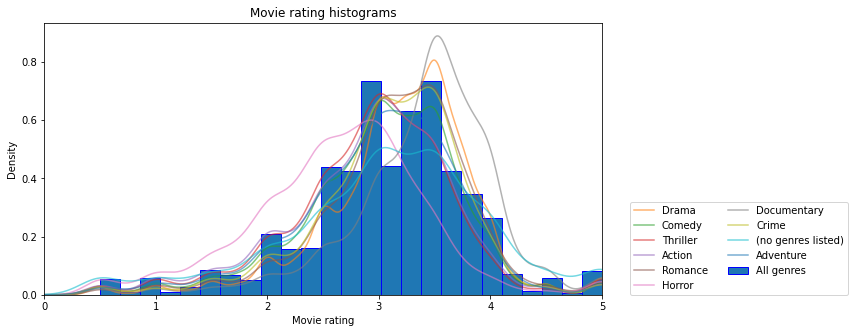

In [ ]:
# Compute the mean rating for each movie
movie_ratings = ratings.groupby('movieId')['rating'].mean()

# Plot a histogram of all ratings
movie_ratings.hist(bins=25, grid=False, edgecolor='b', density=True, label='All genres', figsize=(10,5))

# Compute the number of movies in each genre
genre_counts = movies[genres_unique['genre']].sum().sort_values(ascending=False)

# Initialize an empty list to capture basic statistics by genre
genre_stats = []

# Plot a KDE line for each of the top 10 genres
for genre in genre_counts[:10].index:
    # Subset movies and ratings by the current genre
    genre_movies = movies[movies[genre]]
    genre_ratings = ratings[ratings.movieId.isin(genre_movies.movieId)]
    # Compute the mean rating for each movie in the current genre
    genre_movie_ratings = genre_ratings.groupby('movieId')['rating'].mean()
    # Plot a KDE line for the current genre
    genre_movie_ratings.plot(grid=False, alpha=0.6, kind='kde', label=genre)
    # Compute basic statistics for the current genre
    genre_avg_rating = genre_movie_ratings.mean()
    genre_std_rating = genre_movie_ratings.std()
    # Add the statistics to the list
    genre_stats.append((genre, genre_avg_rating, genre_std_rating))

# Set axis limits, labels, and title
plt.xlim(0, 5)
plt.xlabel('Movie rating')
plt.ylabel('Density')
plt.title('Movie rating histograms')

# Add a legend outside of the plot area
plt.legend(loc=(1.05, 0), ncol=2)

# Show the plot
plt.show()

All genres show similar patterns in ratings trends i.e. all have average ratings of around 3.5 except **Horror**.

Horror movies received a lower rating in general compared to other top genres.

**Distribution of Rating across genres**

The box shows the interquartile range (IQR) of the ratings, which is the range of values between the 25th and 75th percentiles of the ratings. The line inside the box represents the median rating, and the whiskers show the range of the ratings that fall outside the IQR. Outliers are shown as individual points beyond the whiskers.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


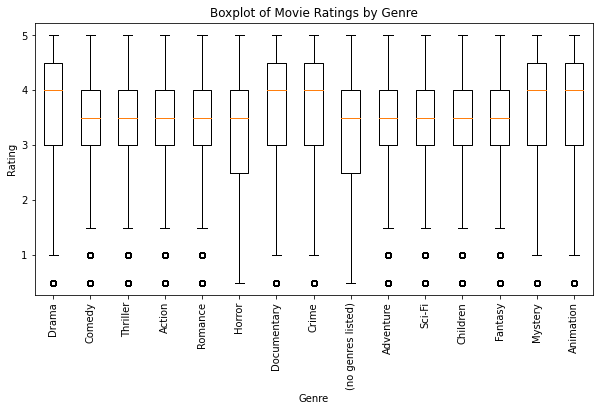

In [ ]:
# Compute the mean rating for each movie
movie_ratings = ratings.groupby('movieId')['rating'].mean()

# Compute the number of movies in each genre
genre_counts = movies[genres_unique['genre']].sum().sort_values(ascending=False)

# Keep only the top 10 genres
top_genres = genre_counts[:15].index

# Subset movies and ratings by the top genres
top_genre_movies = movies[movies[top_genres].any(axis=1)]
top_genre_ratings = ratings[ratings.movieId.isin(top_genre_movies.movieId)]

# Merge the ratings with the movies and genres data
top_genre_data = top_genre_ratings.merge(top_genre_movies[['movieId'] + list(top_genres)], on='movieId')

# Initialize an empty list to capture the boxplot data
boxplot_data = []

# Iterate over the top genres and create a list of ratings for each genre
for genre in top_genres:
    genre_ratings = top_genre_data[top_genre_data[genre] == True]['rating']
    boxplot_data.append(genre_ratings.tolist())

# Plot a boxplot for the ratings of the top genres
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(boxplot_data)

# Set the x axis tick labels to the genre names
ax.set_xticklabels(top_genres, rotation=90)

# Set the axis labels and title
ax.set_xlabel('Genre')
ax.set_ylabel('Rating')
ax.set_title('Boxplot of Movie Ratings by Genre')

# Show the plot
plt.show()


We can observe that Comedy, Thriller, Action and Romance are rated with almost same consistency howerver no genre listed movies show a wide deviation in terms of rating percentile.

**Tags Associated with Movies**

This plot is showing a Wordcloud visualization of the most frequently occurring tags in a dataset of tags associated with movies. The larger the size of the word in the cloud, the more frequently it appears in the tag data

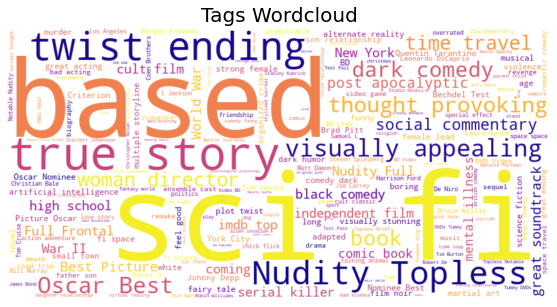

In [ ]:
# Convert the 'tag' column to string type
tags['tag'] = tags['tag'].astype(str)

# Concatenate all tags into a single string
text = ' '.join(tags['tag'].values)

# Create a WordCloud object with some settings
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma', max_words=200)

# Generate the wordcloud from the text
wordcloud.generate(text)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tags Wordcloud', fontsize=20)
plt.show()


We can observe the most used tags in the entire dataset, Sci - fi, true story are among most used the tags

**Tags used by the highest rated movies**

Let's now find out the tags that are used by the most rated movies to find

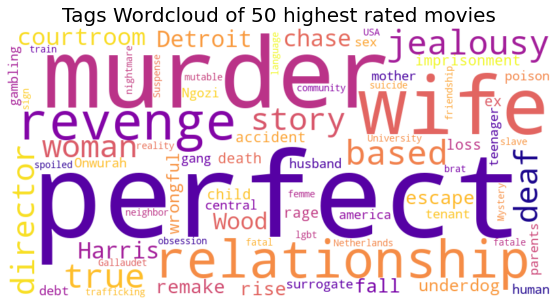

In [ ]:
# Calculate the average rating for each movie
avg_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()

# Sort the movies by their average rating in descending order and select the top 50 movies
top_movies = avg_ratings.sort_values(by='rating', ascending=False).head(50)

# Merge the tags dataframe with the top 50 movies dataframe to get the tags for these movies
tags_top_movies = pd.merge(tags, top_movies, on='movieId', how='inner')

# Concatenate all tags into a single string
text = ' '.join(tags_top_movies['tag'].values)

# Create a WordCloud object with some settings
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma', max_words=200)

# Generate the wordcloud from the text
wordcloud.generate(text)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tags Wordcloud of 50 highest rated movies', fontsize=20)
plt.show()

We can observe murder, perfect, relationship are the tags most used by 50 highest rated movies

**Movie Rating distribution per user**

To observe how each user has rated a movie, I plot a cummulative distribution function to find trends on the ratings given by each user

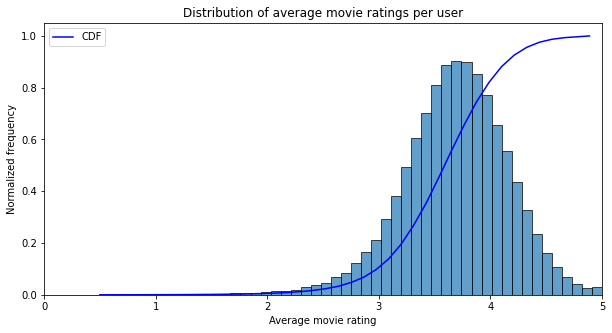

In [ ]:
# Compute the average rating per user
ratings_per_user = ratings[['userId', 'rating']].groupby('userId').mean()

# Plot a histogram of the ratings
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.hist(ratings_per_user['rating'], bins=50, density=True,
         edgecolor='black', alpha=0.7)

# Compute and plot the cumulative distribution function (CDF)
values, base = np.histogram(ratings_per_user['rating'], bins=40, density=True)
cumulative = np.cumsum(values) * np.diff(base).mean()
plt.plot(base[:-1], cumulative, c='blue', label='CDF')

# Set the plot parameters
plt.xlim(0, 5)
plt.legend()
plt.xlabel('Average movie rating')
plt.ylabel('Normalized frequency')
plt.title('Distribution of average movie ratings per user')

# Show the plot
plt.show()


Users have a positive bias in general, with roughly 95% of their average ratings above the mid-point of 2.5

**Number of ratings given by each user**

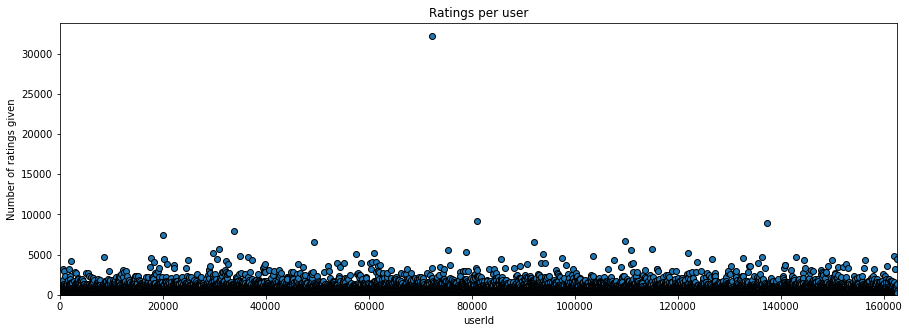

In [18]:
# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,len(dftmp.index))
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()


We can observe that most users have rated less than 100 movies however many have rated more than 1000 while one has rated more than 30000!!

In [ ]:
# Find the most popular movie with the highest average rating among movies that have received more than 40,000 ratings
movies['movieId'] = movies['movieId'].astype(int)
tmp = ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings > 40000]].groupby('movieId').mean()
best = movies.set_index('movieId').loc[tmp.rating.idxmax()].title
print('The most popular movie with the highest average rating is %s.' % best)

<ipython-input-38-6c3688c65644>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['movieId'] = movies['movieId'].astype(int)


The most popular movie with the highest average rating is Shawshank Redemption, The.
